In [ ]:
"""
TESS/ZTF Transient Classification Project

This notebook can be used to run the entire ML pipeline in one place.
"""

'\nTESS/ZTF Transient Classification Project\n\nThis notebook can be used to run the entire ML pipeline in one place.\n'

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
import sys    
path_to_module = '/content/drive/MyDrive/TESS-ZTF-Transient-Classification'
sys.path.append(path_to_module)

Mounted at /content/drive/


In [ ]:
"""
Step 1: Preprocessing

Reads in raw light curve data and classification info and processes the the data.

Processing steps include:
    - numeric encodings of class
    - use of TESS/ZTF filter IDs
    - timestep creation for each filter ID occurance
    - cut light curves between specific time range
    - skip light curves with no data
    - data augmentation so all light curves have same # of timesteps
"""
from pre_process import read_raw_data, prepare_NN_data,plot_specific

# define file paths
lc_path='/content/drive/MyDrive/TESS-ZTF-Transient-Classification/processed_curves'
transient_path="/content/drive/MyDrive/TESS-ZTF-Transient-Classification/tns_info2 (1).csv"

# get DataFrames from raw file data
light_curves, original_curves, all_transients=read_raw_data(lc_path,transient_path)

# plot specific light curve
plot_specific(original_curves,'2018fzi')

# get data prepared for neural network model
prepared_data=prepare_NN_data(light_curves)



reading raw data...


100%|██████████| 805/805 [00:00<00:00, 12250.16it/s]


Class counts:  Counter({3: 529, 0: 231, 2: 24, 1: 12, 4: 9})
Number of light curves recorded:  805
Number of timesteps in first light curves 269
shape of prepared data:  (805, 269, 4)
[[[-19.0 6 52.20015404552375 55.2394202835179]
  [-19.0 5 0.2884437906196228 43.6977328430779]
  [-16.0 6 -86.12550639162569 38.6609775118237]
  ...
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]

 [[-25.0 6 42.24322507901832 25.4448235881257]
  [-25.0 5 7.6642065318414225 20.6086709806962]
  [-12.0 8 752.7793191587589 164.95286728612626]
  ...
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]]


EPOCHS 5
Splitting data into train and test...
shape of prep_inp and x_train: (805, 269, 4) (805, 269, 4)
shape of prep_out and y_train: (805, 269, 1) (805, 269, 1)
building encoder...
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 269, 4)]     0           []                               
                                                                                                  
 masking_1 (Masking)            (None, 269, 4)       0           ['input_3[0][0]']                
                                                                                                  
 gru1 (GRU)                     (None, 269, 175)     95025       ['masking_1[0][0]']              
                                                                                                  
 gru2 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


805/805 [==============================] - 75s 93ms/sample - loss: 13.3163 - val_loss: 13.5084
Epoch 2/5
805/805 [==============================] - 69s 86ms/sample - loss: 13.0171 - val_loss: 13.4505
Epoch 3/5
805/805 [==============================] - 69s 85ms/sample - loss: 13.0003 - val_loss: 13.2625
Epoch 4/5
805/805 [==============================] - 72s 90ms/sample - loss: 12.9967 - val_loss: 13.4978
Epoch 5/5
805/805 [==============================] - 68s 85ms/sample - loss: 12.9961 - val_loss: 13.2544


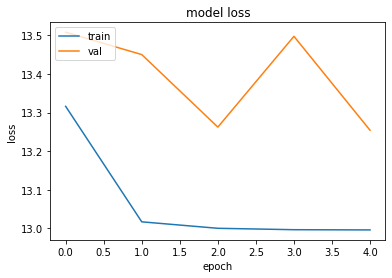

test_inp_one shape:  (162, 269, 4)
test_inp_two shape:  (162, 269, 2)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 269, 4)]     0           []                               
                                                                                                  
 masking_1 (Masking)            (None, 269, 4)       0           ['input_3[0][0]']                
                                                                                                  
 gru1 (GRU)                     (None, 269, 175)     95025       ['masking_1[0][0]']              
                                                                                                  
 gru2 (GRU)                     (None, 269, 150)     147150      ['gru1[0][0]']                   
                      

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
 10%|█         | 1/10 [00:01<00:13,  1.46s/it]

shape of predicted data:  (269, 1)


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


done predicting
using t-SNE...


100%|██████████| 3/3 [00:00<00:00, 22114.08it/s]


t-sne shape:  (276, 2)


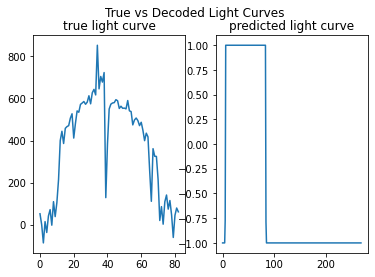

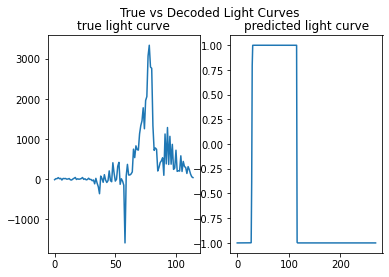

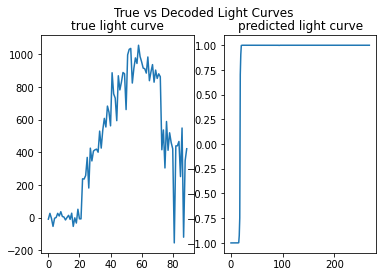

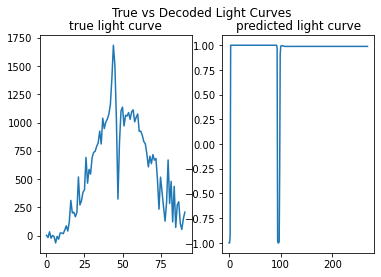

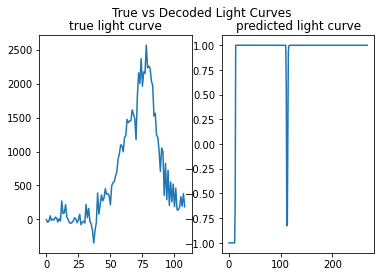

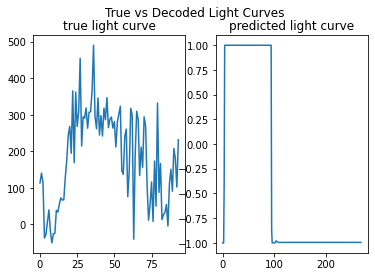

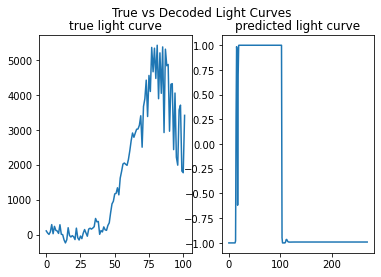

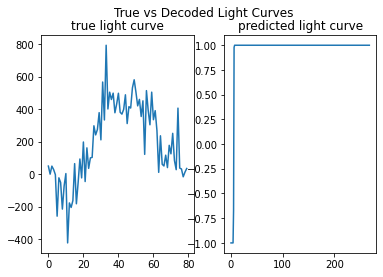

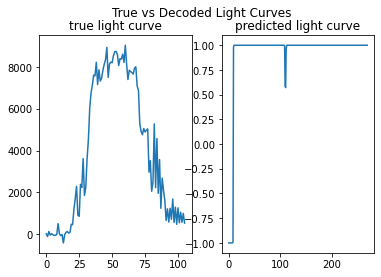

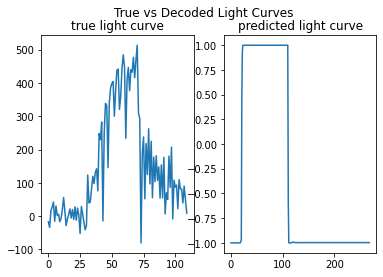

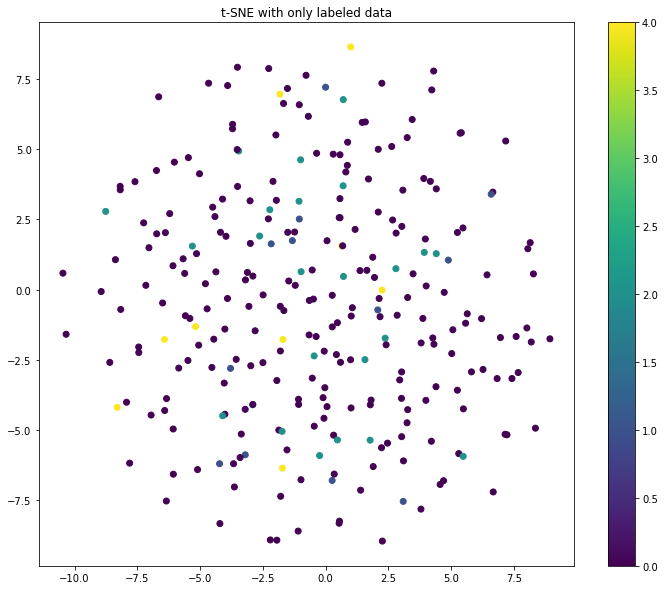

100%|██████████| 3/3 [00:00<00:00, 26214.40it/s]


t-sne shape:  (805, 2)


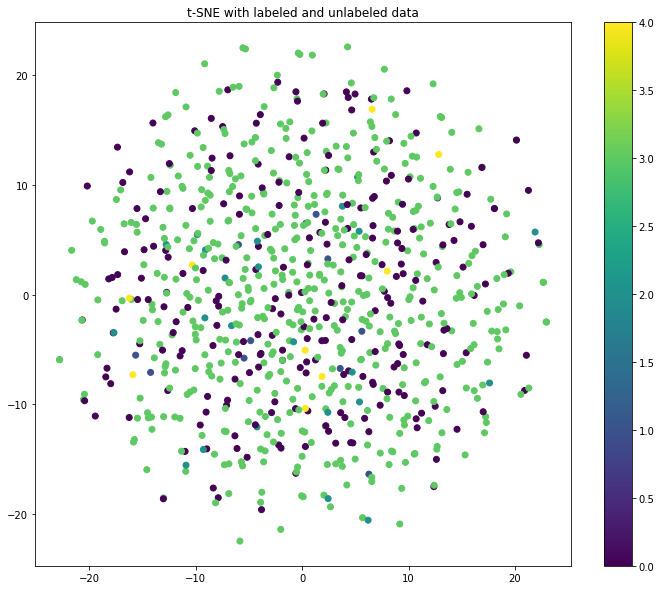

In [ ]:
"""
Step 2: Recurrent Variational Autoencoder
*Unsupervised*
    
Builds a variational autoencoder that takes in time-series
light curve data and produces lower-dimensional representations to be used
for classificiation.

Trains and tests the model, extracts the encoder.

Plots a 2D t-SNE representation of light curves in their latent space.
"""
from NN_model import RVAE

# make RVAE object
rvae= RVAE(prepared_data)
print('EPOCHS', rvae.epochs)

# split prepped data into training and testing sets
x_train, x_test, y_train, y_test = rvae.split_prep_data()

# build model and encoder 
model,encoder=rvae.build_connected_model()

# get trained model
trained_model=rvae.train_model(model,x_train, x_test, y_train, y_test)

# test the trained model
rvae.test_model(trained_model,x_test,y_test)

# t-SNE plot
rvae.t_SNE_plot(light_curves,encoder)

Num GPUs Available:  1
Splitting data for RF...
shape of x_train and x_test: (234, 269, 4) (42, 269, 4)
shape of y_train and y_test: (234,) (42,)
shape of x_unclassified: (529, 269, 4)
making encodings...
shape of encodings:  (234, 30) (42, 30) (529, 30)
building classifier...
shape of encodings:  (234, 30) (42, 30) (529, 30)
y_train counts:  Counter({0: 194, 2: 23, 1: 11, 4: 6})
y_test counts:  Counter({0: 37, 4: 3, 2: 1, 1: 1})
y_pred counts:  Counter({1: 18, 0: 12, 4: 9, 2: 3})
ACCURACY OF THE MODEl:  33.0 %
Confusion Matrix:
Predicted Species   0   1  2  4
Actual Species                 
0                  12  17  1  7
1                   0   0  0  1
2                   0   0  1  0
4                   0   1  1  1
Unlabeled Classifications: 
[0 0 4 4 1 4 4 1 4 0 0 4 1 2 0 0 0 0 4 0 4 2 2 1 1 1 1 0 1 0 1 2 1 1 4 0 0
 1 0 1 4 4 0 2 0 0 1 0 0 0 1 4 2 4 0 4 0 0 1 4 1 0 1 1 2 4 0 4 4 4 0 1 4 4
 0 4 1 4 1 0 4 1 1 1 4 1 0 1 4 0 0 1 0 1 1 1 1 0 4 0 0 4 1 1 1 4 2 2 0 0 0
 4 2 1 1 4 0 0 0 4 1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


BalancedRandomForestClassifier(n_estimators=20)

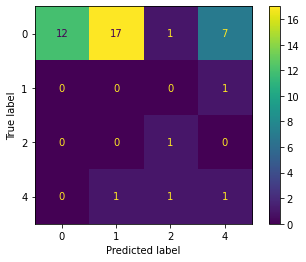

In [ ]:
"""
Step 3: Balanced Random Forest Classifier
*Supervised*

Creates a Balanced Random Forest Classifier that takes in encoded light curves and classifies them.

Uses the trained encoder from the RVAE model to encode light curves.

Trains the classifier on labeled data, tests on both labeled and unlabeled.
"""
from classify import RandomForest

rf= RandomForest(light_curves,prepared_data,encoder)

# split data set for supervised training
x_train, x_test, y_train, y_test, x_unclassified= rf.create_test_train()

# encode input data
x_train_enc,x_test_enc,x_unclassified_enc=rf.make_encodings(x_train, x_test, x_unclassified)

# build and train the classifier
rf.build_classier(x_train_enc,x_test_enc,x_unclassified_enc,y_train,y_test)

# # classify an example light curve
# rf.classify(rf, original_curves, filename='2018evo')